# Libraries & Data

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import Model

In [2]:
# DO NOT CHANGE THIS CODE

#Load the tf_flowers dataset and split training/validation/test set.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # Name of the dataset to load.
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # Split to training, validation and test set.
    with_info=True, # Return the dataset information and keep in 'metadata' variable.
    as_supervised=True,  # boolean, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

# Show the data information (metadata)
print("Metadata: " +str(metadata))

# Show the number of classes of the dataset
num_classes = metadata.features['label'].num_classes
print("Number of classes: " + str(num_classes))

Metadata: tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)
Number of classes: 5


Image shape: (333, 500, 3)
(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


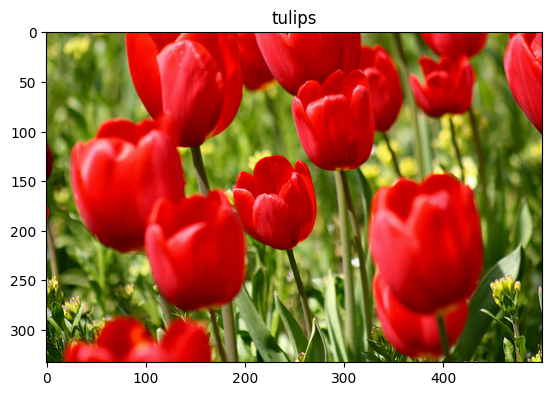

In [3]:
# Show a data sample from the dataset
get_label_name = metadata.features['label'].int2str # Return the function mapping integer label to string label

# Get the first data sample in the training set
image, label = next(iter(train_ds))
plt.imshow(image) # Plot the image.
plt.title(get_label_name(label)) # Add the flower name to the plot.
print("Image shape: " + str(image.shape))

# Print some of image tensors
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

# Data Processing & Augmentation

In [4]:
# Data processing with resizing and resclaing
IMG_SIZE = 96
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE), # Resize the image to a fixed size
  tf.keras.layers.Rescaling(1./255) # Normalize pixel values
])

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Random flip
    tf.keras.layers.RandomRotation(0.2),  # Random rotation with angle
    tf.keras.layers.RandomZoom(0.1),  # Random zoom
    tf.keras.layers.RandomContrast(0.1),  # Random contrast adjustment
    tf.keras.layers.GaussianNoise(0.1),  # Add Gaussian noise
])


In [6]:
# Prepare the data: resize and scale, then augment.
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale the dataset 'ds'.
  # lambda is an expression; Input (x is data feature, y is data label); Ouput (only resize and rescale the data feature x).
  # tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=tf.data.AUTOTUNE) # Number data samples to process asynchronously in parallel at a time.

  # shuffle=False by default (i.e., do not shuffle the dataset 'ds' by default)
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)

  # Get a batch_size of data samples from the dataset 'ds'.
  ds = ds.batch(batch_size=128)

  # augment=False by default (i.e., do not augment the dataset 'ds' by default).
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

  # Prepare the data in the buffer.
  # When tf.data.AUTOTUNE is used, the buffer size is dynamically tuned.
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Resize and rescale the training set; shuffle and augment it.
train_ds_ = prepare(train_ds, shuffle=True, augment=True)
#train_ds_ = prepare(train_ds)
# Resize and rescale the validation set; DO NOT shuffle and augment it.
val_ds_ = prepare(val_ds)

# Resize and rescale the test set; DO NOT shuffle and augment it.
test_ds_ = prepare(test_ds)

Image shape:  (96, 96, 3)


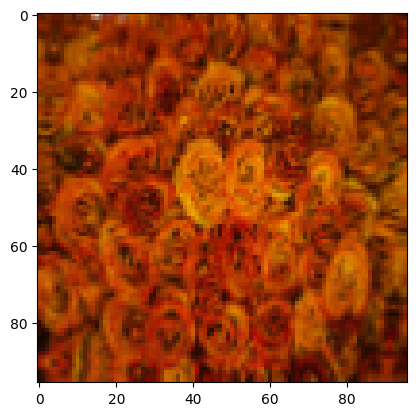

Image shape:  (96, 96, 3)


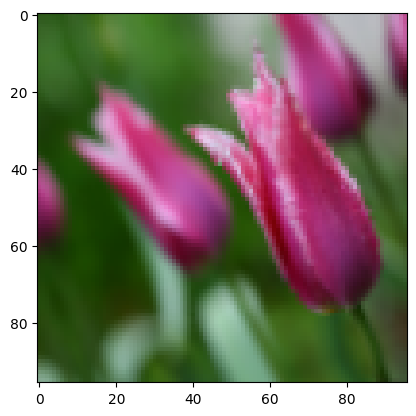

In [8]:
# Plot some data samples in the training data after processing
count = 0
for image_batch in tfds.as_numpy(train_ds_):
  if count < 2:
    print("Image shape: ", image_batch[0][count].shape)
    plt.imshow(image_batch[0][count])
    plt.show()
  count = count + 1

# Build model with Transfer Learning (Xception)

After experimenting with different models: resnet and efficientnet, Xception seems to work best for in my case.


In [9]:
# Load the EfficientNetV2 model
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
# Print model summary
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

In [10]:
# Extract the last layer from third block of vgg16 model
last_layer = base_model.get_layer('block14_sepconv2_act').output

# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x= BatchNormalization()(x) # Add batch normalization layer.
x = Dense(128, activation='relu')(x) # Add a fully connected layer.
x = Dense(128, activation='relu')(x) # Add a fully connected layer.
x = Dropout(0.5)(x) # Add a dropout layer with probability 0.5.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.

##########

# Show the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


# Freeze all layers

In [11]:
# Define a new model by grouping layers into an object with training and inference features.
complete_model = Model(inputs=base_model.input, outputs=pred)

# Freeze the base model (feature extraction layers)
base_model.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_freeze = Model(inputs=base_model.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
#complete_model_freeze.summary()

In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
complete_model_freeze.compile(optimizer=optimizer, # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

In [13]:
# Set training epochs and batch size
training_epochs=30
training_batch_size=128

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Quantity to monitor for improvement, e.g., validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)


# Train the model
history_freeze = complete_model_freeze.fit(
  train_ds_,
  validation_data=val_ds_,
  epochs=training_epochs,
  batch_size=training_batch_size,
  callbacks=[early_stopping]
)

Epoch 1/30
21/21 [==============================] - 9s 105ms/step - loss: 1.5378 - accuracy: 0.4122 - val_loss: 1.0411 - val_accuracy: 0.6715
Epoch 2/30
21/21 [==============================] - 1s 39ms/step - loss: 1.1022 - accuracy: 0.5944 - val_loss: 0.9490 - val_accuracy: 0.6878
Epoch 3/30
21/21 [==============================] - 1s 38ms/step - loss: 0.9448 - accuracy: 0.6559 - val_loss: 0.8739 - val_accuracy: 0.7296
Epoch 4/30
21/21 [==============================] - 1s 35ms/step - loss: 0.9163 - accuracy: 0.6602 - val_loss: 0.8138 - val_accuracy: 0.7405
Epoch 5/30
21/21 [==============================] - 1s 36ms/step - loss: 0.8473 - accuracy: 0.6847 - val_loss: 0.7741 - val_accuracy: 0.7441
Epoch 6/30
21/21 [==============================] - 1s 30ms/step - loss: 0.8161 - accuracy: 0.7046 - val_loss: 0.7344 - val_accuracy: 0.7423
Epoch 7/30
21/21 [==============================] - 1s 35ms/step - loss: 0.7990 - accuracy: 0.7100 - val_loss: 0.7089 - val_accuracy: 0.7495
Epoch 8/30
2

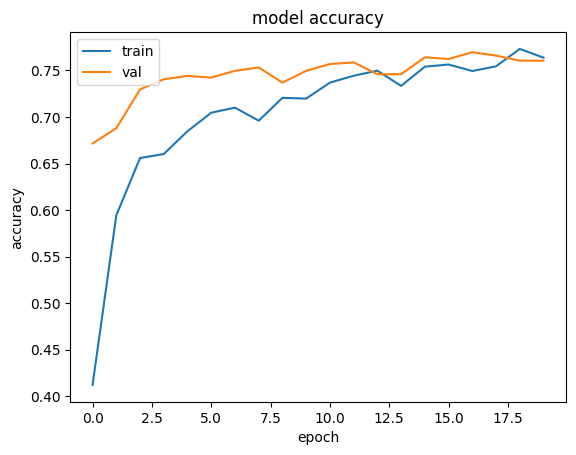

In [14]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_freeze.history['accuracy'])
plt.plot(history_freeze.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Choose a model to evaluate
#chosen_model = model # Model built from scratch
chosen_model = complete_model_freeze # Model 1 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze # Model 2 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze_top # Model 3 with transfer learning

# Evaluate the model accuracy using the function model.evaluate()
model_eval = chosen_model.evaluate(test_ds_)
print("List of metrics" + str(chosen_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

5/5 [==============================] - 0s 76ms/step - loss: 0.5970 - accuracy: 0.7818
List of metrics['loss', 'accuracy']
Test loss: 0.5970394015312195
Test accuracy: 0.7818182110786438


# Fine tune Approach by unfreeze some layers

In [13]:
# Fine-tune from this layer onwards
fine_tune_at = 70

# Un-freeze only the top layers of the model
base_model.trainable = True # First, un-freeze all layers of the base model.
for layer in base_model.layers[:fine_tune_at]: # Then freeze all the layers before the `fine_tune_at` layer
  print("Freeze layer: ", layer.name)
  layer.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_unfreeze_top = Model(inputs=base_model.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_unfreeze_top.summary()

Freeze layer:  input_1
Freeze layer:  block1_conv1
Freeze layer:  block1_conv1_bn
Freeze layer:  block1_conv1_act
Freeze layer:  block1_conv2
Freeze layer:  block1_conv2_bn
Freeze layer:  block1_conv2_act
Freeze layer:  block2_sepconv1
Freeze layer:  block2_sepconv1_bn
Freeze layer:  block2_sepconv2_act
Freeze layer:  block2_sepconv2
Freeze layer:  block2_sepconv2_bn
Freeze layer:  conv2d
Freeze layer:  block2_pool
Freeze layer:  batch_normalization
Freeze layer:  add
Freeze layer:  block3_sepconv1_act
Freeze layer:  block3_sepconv1
Freeze layer:  block3_sepconv1_bn
Freeze layer:  block3_sepconv2_act
Freeze layer:  block3_sepconv2
Freeze layer:  block3_sepconv2_bn
Freeze layer:  conv2d_1
Freeze layer:  block3_pool
Freeze layer:  batch_normalization_1
Freeze layer:  add_1
Freeze layer:  block4_sepconv1_act
Freeze layer:  block4_sepconv1
Freeze layer:  block4_sepconv1_bn
Freeze layer:  block4_sepconv2_act
Freeze layer:  block4_sepconv2
Freeze layer:  block4_sepconv2_bn
Freeze layer:  con

In [14]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
complete_model_unfreeze_top.compile(optimizer=optimizer, # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

In [15]:
# Set training epochs and batch size
training_epochs=30
training_batch_size=128

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Quantity to monitor for improvement, e.g., validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)

# Train the model
history_unfreeze_top = complete_model_unfreeze_top.fit(
  train_ds_,
  validation_data=val_ds_,
  epochs=training_epochs,
  batch_size=training_batch_size,
  callbacks=[early_stopping]
)

Epoch 1/30
21/21 [==============================] - 23s 140ms/step - loss: 1.6491 - accuracy: 0.3445 - val_loss: 1.3002 - val_accuracy: 0.5572
Epoch 2/30
21/21 [==============================] - 1s 46ms/step - loss: 1.1854 - accuracy: 0.5485 - val_loss: 1.1115 - val_accuracy: 0.6497
Epoch 3/30
21/21 [==============================] - 1s 42ms/step - loss: 0.9665 - accuracy: 0.6294 - val_loss: 0.9538 - val_accuracy: 0.6461
Epoch 4/30
21/21 [==============================] - 1s 48ms/step - loss: 0.8421 - accuracy: 0.6800 - val_loss: 0.8238 - val_accuracy: 0.6915
Epoch 5/30
21/21 [==============================] - 1s 47ms/step - loss: 0.7973 - accuracy: 0.7053 - val_loss: 0.7515 - val_accuracy: 0.7332
Epoch 6/30
21/21 [==============================] - 1s 46ms/step - loss: 0.6866 - accuracy: 0.7411 - val_loss: 0.6935 - val_accuracy: 0.7387
Epoch 7/30
21/21 [==============================] - 1s 40ms/step - loss: 0.6109 - accuracy: 0.7785 - val_loss: 0.6835 - val_accuracy: 0.7314
Epoch 8/30


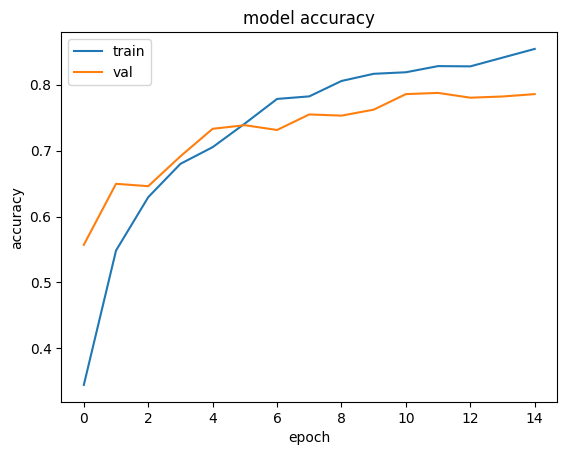

In [16]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_unfreeze_top.history['accuracy'])
plt.plot(history_unfreeze_top.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# Choose a model to evaluate
#chosen_model = model # Model built from scratch
chosen_model = complete_model_unfreeze_top # Model 1 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze # Model 2 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze_top # Model 3 with transfer learning

# Evaluate the model accuracy using the function model.evaluate()
model_eval = chosen_model.evaluate(test_ds_)
print("List of metrics" + str(chosen_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

5/5 [==============================] - 0s 79ms/step - loss: 0.5345 - accuracy: 0.8255
List of metrics['loss', 'accuracy']
Test loss: 0.5345066785812378
Test accuracy: 0.8254545331001282


# Unfreeze all layers

In [11]:
# Unfreeze the base model (feature extraction layers)
base_model.trainable = True

# Define a new model by grouping layers into an object with training and inference features.
complete_model_unfreeze = Model(inputs=base_model.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_unfreeze.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]']    

In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
complete_model_unfreeze.compile(optimizer=optimizer, # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

In [13]:
# Set training epochs and batch size
training_epochs=30
training_batch_size=128

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Quantity to monitor for improvement, e.g., validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)


# Train the model
history_unfreeze = complete_model_unfreeze.fit(
  train_ds_,
  validation_data=val_ds_,
  epochs=training_epochs,
  batch_size=training_batch_size,
  callbacks=[early_stopping]
)

Epoch 1/30
21/21 [==============================] - 38s 182ms/step - loss: 1.5912 - accuracy: 0.3768 - val_loss: 1.3165 - val_accuracy: 0.5299
Epoch 2/30
21/21 [==============================] - 2s 71ms/step - loss: 1.1839 - accuracy: 0.5395 - val_loss: 1.1319 - val_accuracy: 0.6279
Epoch 3/30
21/21 [==============================] - 2s 71ms/step - loss: 0.9555 - accuracy: 0.6399 - val_loss: 0.9962 - val_accuracy: 0.6770
Epoch 4/30
21/21 [==============================] - 2s 71ms/step - loss: 0.7770 - accuracy: 0.7073 - val_loss: 0.9008 - val_accuracy: 0.7114
Epoch 5/30
21/21 [==============================] - 2s 70ms/step - loss: 0.6788 - accuracy: 0.7458 - val_loss: 0.7559 - val_accuracy: 0.7623
Epoch 6/30
21/21 [==============================] - 2s 70ms/step - loss: 0.6131 - accuracy: 0.7664 - val_loss: 0.6738 - val_accuracy: 0.7786
Epoch 7/30
21/21 [==============================] - 2s 71ms/step - loss: 0.5559 - accuracy: 0.7999 - val_loss: 0.6050 - val_accuracy: 0.7985
Epoch 8/30


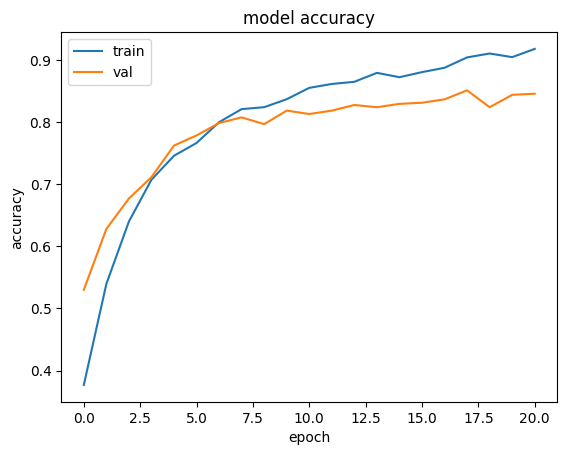

In [14]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_unfreeze.history['accuracy'])
plt.plot(history_unfreeze.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Choose a model to evaluate
#chosen_model = model # Model built from scratch
chosen_model = complete_model_unfreeze # Model 1 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze # Model 2 with transfer learning
#chosen_model = complete_model_vgg16_unfreeze_top # Model 3 with transfer learning

# Evaluate the model accuracy using the function model.evaluate()
model_eval = chosen_model.evaluate(test_ds_)
print("List of metrics" + str(chosen_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

5/5 [==============================] - 0s 81ms/step - loss: 0.4108 - accuracy: 0.8673
List of metrics['loss', 'accuracy']
Test loss: 0.4108090400695801
Test accuracy: 0.8672727346420288


# Conclusion

From what I tried, it seems like unfreeze all the layers will result in the highest accuracy and freeze all layers will result in the lowest accuracy in the 3 approachs.